In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [3]:
sns.set_context("paper")
sns.set_style('ticks')

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.dpi'] = 600

In [4]:
paths = ["andmed/all_four/const_order.csv", "andmed/all_four/const_reverse.csv", "andmed/all_four/sin_order.csv", "andmed/all_four/sin_reverse.csv"]
df_koik = pd.concat([utils.read_aggregated_data(path) for path in paths], axis=0)
df_koik.shape

(1896, 41)

In [5]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

def treeni_ols_no_p_drop(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    X = sm.add_constant(X)
    kasutusel_featured = {col: 1 for col in X.columns}

    model = sm.OLS(y, X)

    results = model.fit()

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    print()
    # print(results.summary())
    return results, X, y

In [6]:
def muuda_veergude_nimed_eestikeelseks(df):
    eesti_nimed = {
        'const': 'Konstant',
        'my_bpoints': 'Minu murde punktid',
        'neighbour_bpoints': 'Naabrite murde punktid',
        'distant_bpoints': 'Kaugemate murde punktid',
        'my_raw_mean2': 'Minu keskmine 2',
        'neighbour_raw_mean2': 'Naabrite keskmine 2',
        'distant_raw_mean2': 'Kaugemate keskmine 2',
        'my_points': 'Minu punktid',
        'neighbour_points': 'Naabrite punktid',
        'distant_points': 'Kaugemate punktid',
        'my_points_m1': 'Minu pöördpunktid',
        'my_points_log': 'Minu punktide logaritm',
        'my_points_logm1': 'Minu pöördpunktide logaritm',
        'neighbour_points_m1': 'Naabrite pöördpunktid',
        'neighbour_points_log': 'Naabrite punktide logaritm',
        'neighbour_points_logm1': 'Naabrite pöördpunktide logaritm',
        'distant_points_m1': 'Kaugemate pöördpunktid',
        'distant_points_log': 'Kaugemate punktide logaritm',
        'distant_points_logm1': 'Kaugemate pöördpunktide logaritm',
        'mse_treeningul': 'MSE treeningul',
    }
    df = df.rename(columns=eesti_nimed)
    return df

# Treenime OLS koos kõigi tunnustega ja ei võta midagigi välja

In [7]:
Xid, yid = [], []

for r, n, k in regioonide_combod:

    andmestikud_koos = pd.concat([utils.read_aggregated_data(
        paths[p]) for p in range(4)], ignore_index=True)
    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)
    Xid.append(X)
    yid.append(y)


In [8]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result, newX, newy = treeni_ols_no_p_drop(suurX, suury)
result.summary()

0.433704027464205;11.581102038960433;-3914.7316556154747;-3774.9128594766585;


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     322.9
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:56:46   Log-Likelihood:                 1977.4
No. Observations:                8030   AIC:                            -3915.
Df Residuals:                    8010   BIC:                            -3775.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.3614      0.205     -1.766      0.077      -0.762       0.040
Minu murde punktid                  -0.3624      0.013    -28.238      0.000      -0.388      -0.337
Naabrite murde punktid              -0.2491      0.017    -14.974      0.000      -0.282      -0.216
Kaugemate murde punktid             -0.2300      0.017    -13.334      0.000      -0.264      -0.196
Minu keskmine 2                     -0.1131      0.037     -3.076      0.002      -0.185      -0.041
Naabrite keskmine 2                  0.5390      0.035     15.451      0.000       0.471       0.607
Kaugemate keskmine 2                 0.6524      0.025     25.632      0.000       0.603       0.702
Minu punktid                        -0.2056      0.050     -4.096      0.000      -0.304      -0.107
Naabrite punktid                    -0.0373      0.062     -0.601      0.548      -0.159       0.084
Kaugemate punktid                   -0.0654      0.053     -1.244      0.214      -0.168       0.038
Minu pöördpunktid                   -1.3701      0.414     -3.311      0.001      -2.181      -0.559
Minu punktide logaritm               1.1629      0.128      9.078      0.000       0.912       1.414
Minu pöördpunktide logaritm          1.7924      0.544      3.296      0.001       0.726       2.858
Naabrite pöördpunktid                0.8267      0.518      1.596      0.111      -0.189       1.842
Naabrite punktide logaritm          -0.3361      0.176     -1.908      0.056      -0.681       0.009
Naabrite pöördpunktide logaritm     -1.4440      0.710     -2.034      0.042      -2.836      -0.052
Kaugemate pöördpunktid              -0.6712      0.436     -1.539      0.124      -1.526       0.184
Kaugemate punktide logaritm         -0.1475      0.138     -1.068      0.286      -0.418       0.123
Kaugemate pöördpunktide logaritm     0.5508      0.579      0.951      0.341      -0.584       1.686
MSE treeningul                      -0.2851      0.013    -21.597      0.000      -0.311      -0.259
==============================================================================
Omnibus:                     3145.931   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32087.060
Skew:                           1.588   Prob(JB):                         0.00
Kurtosis:                      12.264   Cond. No.                         630.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
summary_table = pd.read_html(result.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\all_regressioon_summary2.xlsx", engine='openpyxl') as writer:
    summary_table[0].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=len(summary_table[0]) + 2, startcol=0, index=True)

# Teeme alumisele ruudule tunnused eraldi analüüsi kokku
## Mypoints kokku

In [10]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value

def treeni_ols(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    X = sm.add_constant(X)
    
    while insignificant_feature:
        
        model = sm.OLS(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    # for k, v in kasutusel_featured.items():
    #     print(v, sep=";", end=";")

    # print(results.rsquared, sep=";", end=";")
    # print(results.mse_model, sep=";", end=";")
    # print(results.aic, sep=";", end=";")
    # print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

In [11]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

In [12]:
def kombineeri_tunnus_mudelist_ja_dfist(mudel, df):
    series = np.zeros(shape=df.shape[0])
    for param in mudel.params.keys():
        if param!="const":
            series += df[param] * mudel.params[param] 
        else:
            series += np.ones(shape=df.shape[0]) * mudel.params["const"]
    return series

In [13]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[[col for col in suurX.columns if "my_points" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result1, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result1.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\minu_punktid_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     494.8
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        12:56:59   Log-Likelihood:                 579.43
No. Observations:                8030   AIC:                            -1149.
Df Residuals:                    8025   BIC:                            -1114.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0568      0.122     -8.681      0.000      -1.295      -0.818
my_points          -0.3762      0.055     -6.811      0.000      -0.484      -0.268
my_points_m1       -3.3876      0.433     -7.818      0.000      -4.237      -2.538
my_points_log       1.3885      0.141      9.879      0.000       1.113       1.664
my_points_logm1     4.0044      0.589      6.800      0.000       2.850       5.159
==============================================================================
Omnibus:                     3091.165   Durbin-Watson:                   0.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32262.662
Skew:                           1.546   Prob(JB):                         0.00
Kurtosis:                      12.320   Cond. No.                         332.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

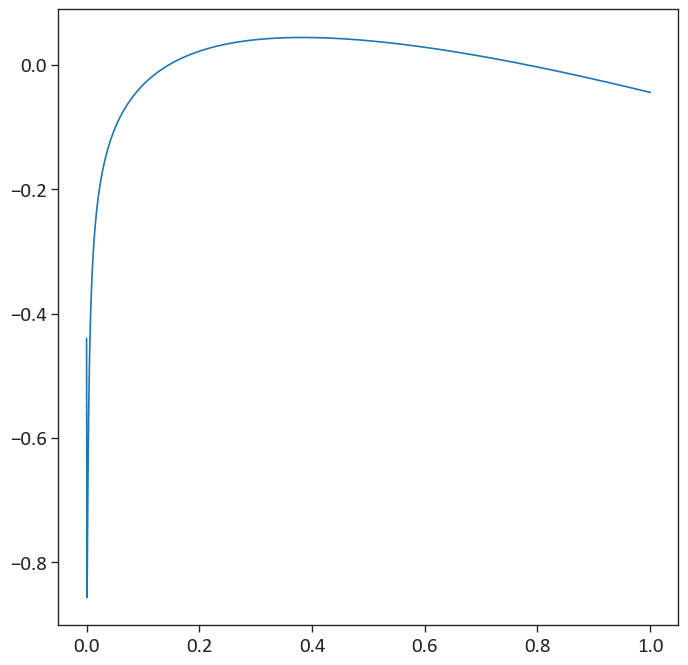

In [14]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape) 

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

# y1 = kombineeri_tunnus_mudelist_ja_dfist(result1, newX)
y1 = punktide_arv * result1.params["my_points"] + poord_punktid * result1.params["my_points_m1"] + log_punktid * result1.params["my_points_log"] + poord_log_punktid * result1.params["my_points_logm1"] + const * result1.params["const"]
sns.lineplot(x=punktide_arv, y=y1)

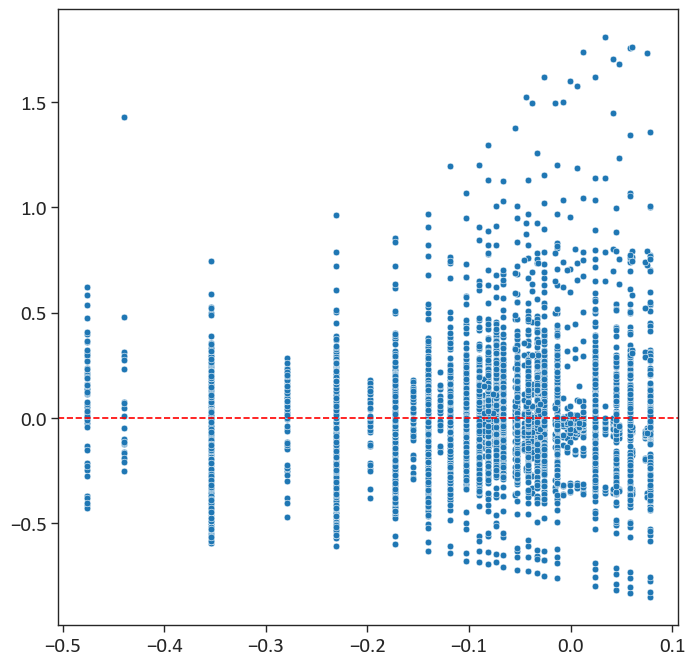

In [15]:
residuals = newy - result1.predict(newX)
sns.scatterplot(x=result1.predict(newX), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

## Neighbour punktid kokku

In [16]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)    

In [17]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[[col for col in suurX.columns if "neighbour_points" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result2, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result2.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\naaber_punktid_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)
    
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     393.9
Date:                Thu, 04 May 2023   Prob (F-statistic):          2.81e-310
Time:                        12:57:08   Log-Likelihood:                 413.99
No. Observations:                8030   AIC:                            -818.0
Df Residuals:                    8025   BIC:                            -783.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.5441      0.172     -3.168      0.002      -0.881      -0.207
neighbour_points          -0.3268      0.071     -4.623      0.000      -0.465      -0.188
neighbour_points_m1       -1.7966      0.568     -3.163      0.002      -2.910      -0.683
neighbour_points_log       0.7729      0.202      3.835      0.000       0.378       1.168
neighbour_points_logm1     1.7054      0.802      2.126      0.034       0.133       3.278
==============================================================================
Omnibus:                     3121.577   Durbin-Watson:                   0.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34990.234
Skew:                           1.543   Prob(JB):                         0.00
Kurtosis:                      12.750   Cond. No.                         440.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

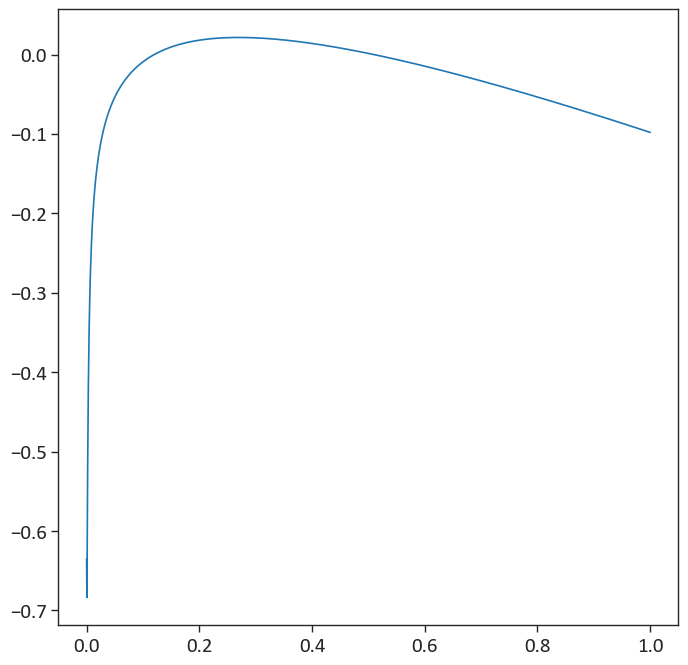

In [18]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape) 

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y2 = punktide_arv * result2.params["neighbour_points"] + poord_punktid * result2.params["neighbour_points_m1"] + log_punktid * result2.params["neighbour_points_log"] + poord_log_punktid * result2.params["neighbour_points_logm1"] + const*result2.params["const"]
sns.lineplot(x=punktide_arv, y=y2)

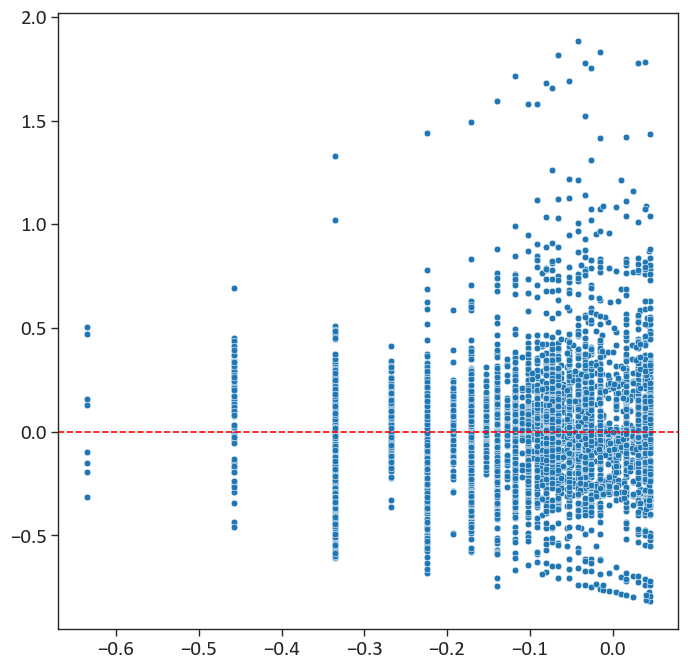

In [19]:
residuals = newy - result2.predict(newX)
sns.scatterplot(x=result2.predict(newX), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

## Distant

In [20]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      


In [21]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
suurX = suurX[[col for col in suurX.columns if "distant_points" in col]]

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result3, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result3.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\kauge_punktid_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     349.8
Date:                Thu, 04 May 2023   Prob (F-statistic):          5.10e-278
Time:                        12:57:17   Log-Likelihood:                 339.56
No. Observations:                8030   AIC:                            -669.1
Df Residuals:                    8025   BIC:                            -634.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8007      0.135     -5.923      0.000      -1.066      -0.536
distant_points          -0.3591      0.060     -6.015      0.000      -0.476      -0.242
distant_points_m1       -2.6190      0.472     -5.552      0.000      -3.544      -1.694
distant_points_log       1.0570      0.157      6.742      0.000       0.750       1.364
distant_points_logm1     2.9404      0.648      4.539      0.000       1.671       4.210
==============================================================================
Omnibus:                     3107.521   Durbin-Watson:                   0.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33748.044
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                      12.557   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

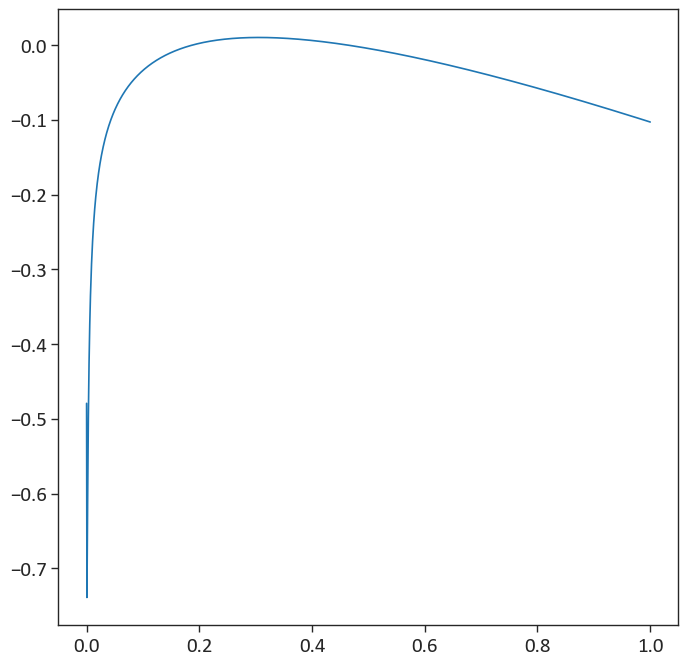

In [22]:
punktide_arv = np.arange(2, 1600)
poord_punktid = 1/punktide_arv
log_punktid = np.log(punktide_arv)
poord_log_punktid = 1/np.log(punktide_arv)
const = np.ones(shape=punktide_arv.shape)

def minimax(X): return (X-np.min(X)) / (np.max(X)-np.min(X))
punktide_arv = minimax(punktide_arv)
poord_punktid = minimax(poord_punktid)
log_punktid = minimax(log_punktid)
poord_log_punktid = minimax(poord_log_punktid)

y3 = punktide_arv * result3.params["distant_points"] + poord_punktid * result3.params["distant_points_m1"] + log_punktid * result3.params["distant_points_log"] + poord_log_punktid * result3.params["distant_points_logm1"] + const * result3.params["const"]
sns.lineplot(x=punktide_arv, y=y3)

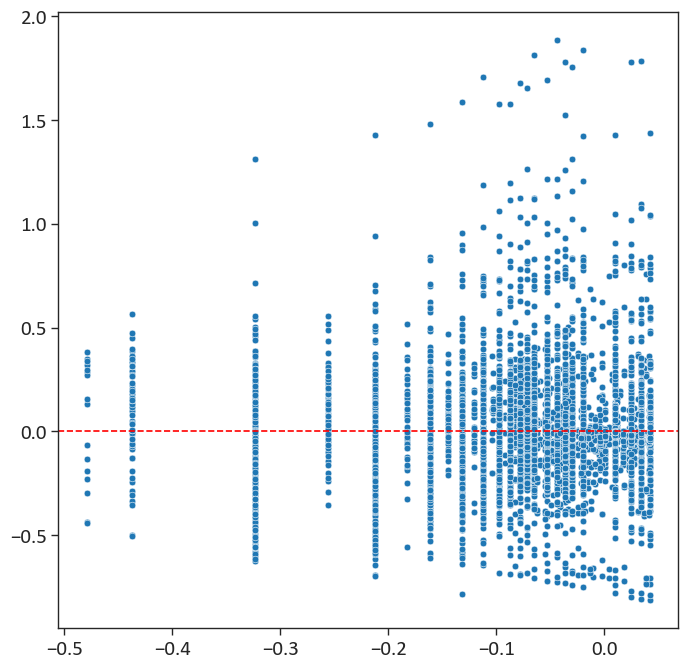

In [23]:
residuals = newy - result3.predict(newX)
sns.scatterplot(x=result3.predict(newX), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

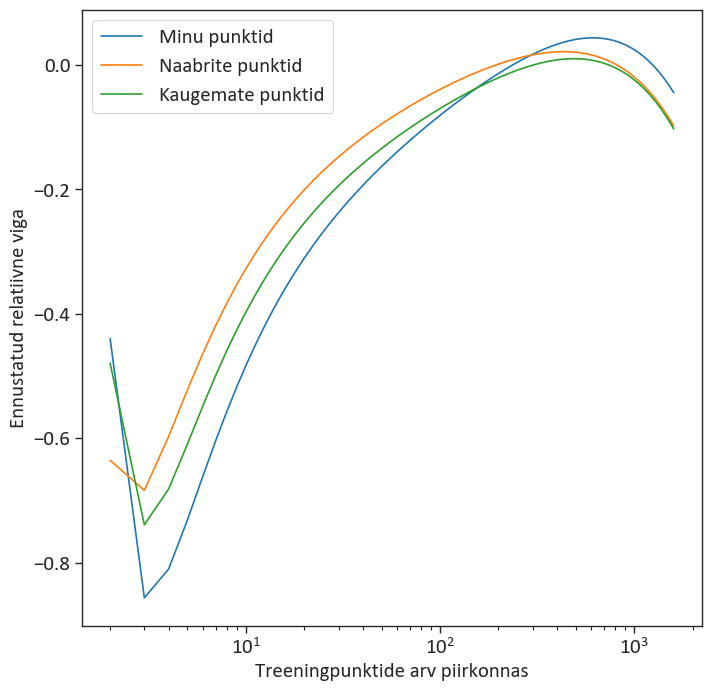

In [24]:
fig, ax = plt.subplots()
ax.set_xscale('log')
sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Minu punktid")
sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naabrite punktid")
sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugemate punktid")

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

plt.savefig("plots/kirjalik_osa/all_points_combos.png")

## Kombineerime need ära

In [25]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)   

In [26]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suurX["my_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result1, suurX)
suurX["neighbour_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result2, suurX)
suurX["distant_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result3, suurX)

suurX.drop([col for col in suurX.columns if "combo" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result4, res4_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result4.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\punkti_combod_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.273
Model:                            OLS   Adj. R-squared (uncentered):              0.273
Method:                 Least Squares   F-statistic:                              1509.
Date:                Thu, 04 May 2023   Prob (F-statistic):                        0.00
Time:                        12:57:32   Log-Likelihood:                          589.61
No. Observations:                8030   AIC:                                     -1175.
Df Residuals:                    8028   BIC:                                     -1161.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
my_points_combo            0.8223      0.043     18.946      0.000       0.737       0.907
neighbour_points_combo     0.2080      0.046      4.514      0.000       0.118       0.298
==============================================================================
Omnibus:                     3143.900   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33742.494
Skew:                           1.570   Prob(JB):                         0.00
Kurtosis:                      12.539   Cond. No.                         4.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
for key, val in result4.params.items():
    print(key, val)

my_points_combo 0.8222761470865895
neighbour_points_combo 0.20801235282850833


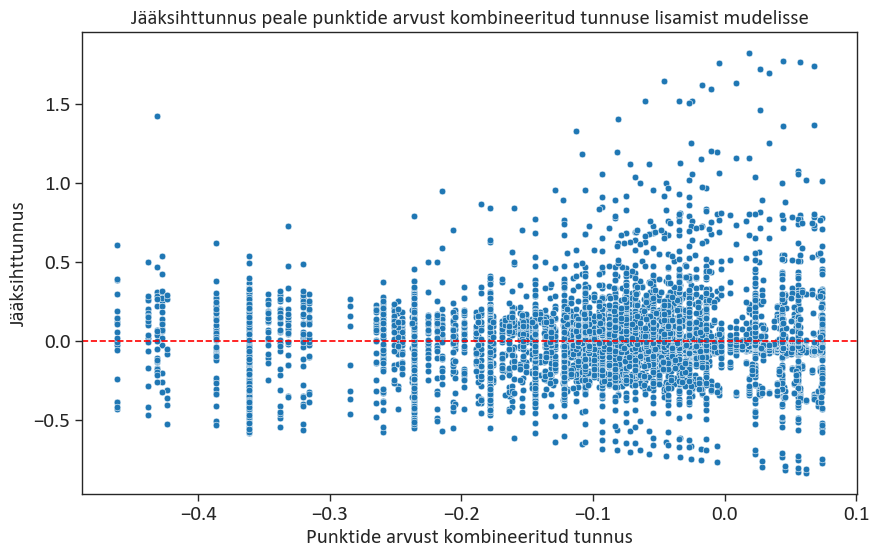

In [53]:
# result4.predict(newX)
model = result4

residuals = newy - model.predict(res4_newX)

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=0.8222761470865895*res4_newX["my_points_combo"]+0.20801235282850833*res4_newX["neighbour_points_combo"], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Punktide arvust kombineeritud tunnus')
plt.ylabel('Jääksihttunnus')
plt.title('Jääksihttunnus peale punktide arvust kombineeritud tunnuse lisamist mudelisse')
plt.savefig('plots/kirjalik_osa/jaak_peale_punkticombosid.png')
plt.show()

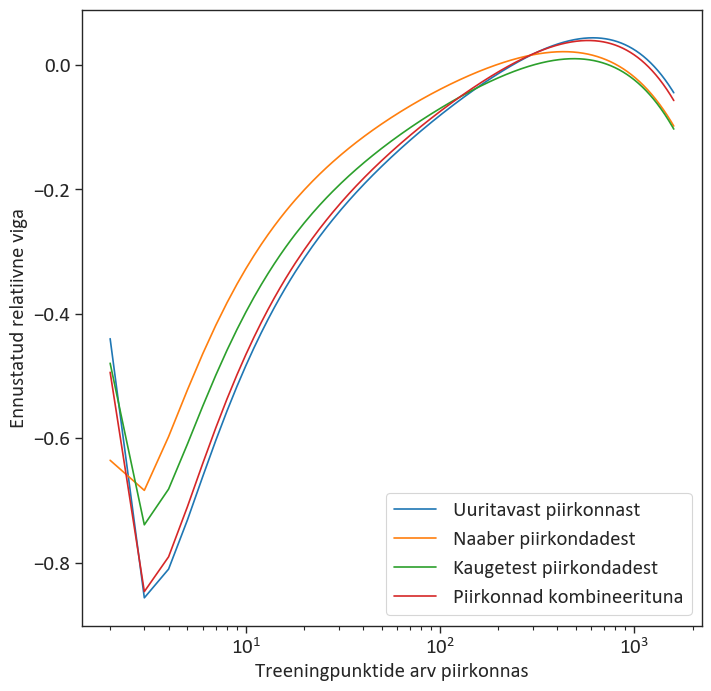

In [29]:
# const4 = np.ones(shape=y1.shape) 
y4 = y1 * result4.params["my_points_combo"] + y2 * result4.params["neighbour_points_combo"]# + const4 * result4.params["const"]

fig, ax = plt.subplots()
ax.set_xscale('log')
sns.lineplot(x=np.arange(2,1600), y=y1, ax=ax, label="Uuritavast piirkonnast")
sns.lineplot(x=np.arange(2,1600), y=y2, ax=ax, label="Naaber piirkondadest")
sns.lineplot(x=np.arange(2,1600), y=y3, ax=ax, label="Kaugetest piirkondadest")
sns.lineplot(x=np.arange(2,1600), y=y4, ax=ax, label="Piirkonnad kombineerituna")

ax.set_xlabel("Treeningpunktide arv piirkonnas")
ax.set_ylabel("Ennustatud relatiivne viga")

plt.savefig("plots/kirjalik_osa/all_points_combos.png")

## Bpoints

In [30]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

In [31]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
tagavarasuurX = suurX.copy()
suurX.drop([col for col in suurX.columns if "bpoints" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
suury = suury - result4.predict(res4_newX)
result5, res5_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result5.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\bpunktide_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     673.9
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        13:02:15   Log-Likelihood:                 1492.1
No. Observations:                8030   AIC:                            -2976.
Df Residuals:                    8026   BIC:                            -2948.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2202      0.008     27.490      0.000       0.204       0.236
my_bpoints           -0.4327      0.012    -35.627      0.000      -0.456      -0.409
neighbour_bpoints    -0.2145      0.015    -14.223      0.000      -0.244      -0.185
distant_bpoints      -0.2054      0.017    -12.382      0.000      -0.238      -0.173
==============================================================================
Omnibus:                     4161.519   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65583.798
Skew:                           2.113   Prob(JB):                         0.00
Kurtosis:                      16.348   Cond. No.                         9.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

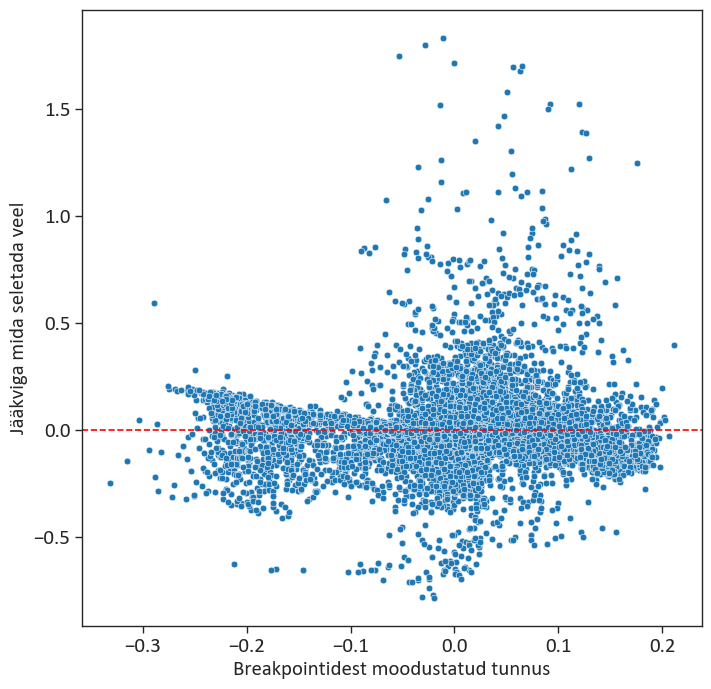

In [32]:
y5 = res5_newX.const * result5.params["const"] +\
    res5_newX.my_bpoints * result5.params["my_bpoints"] + \
    res5_newX.neighbour_bpoints * result5.params["neighbour_bpoints"] + \
    res5_newX.distant_bpoints * result5.params["distant_bpoints"]


fig, ax = plt.subplots()
# ax.set_xscale('log')
def inverse_minimax(X):
    return  X * (1600-2) + 2

residuals = newy - result5.predict(res5_newX)
sns.scatterplot(x=y5, y=residuals, ax=ax)#, hue=tagavarasuurX.neighbour_bpoints)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_title("")
ax.set_xlabel("Breakpointidest moodustatud tunnus")
ax.set_ylabel("Jääkviga mida seletada veel")

plt.savefig("plots/kirjalik_osa/bpoints_combo_kaalud.png")

### Bpoints ja points kombineerituna


In [33]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

In [34]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)
tagavarasuurX = suurX.copy()


suurX["my_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result1, suurX)
suurX["neighbour_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result2, suurX)
suurX["distant_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result3, suurX)

suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result4, suurX)
suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result5, suurX)


suurX.drop([col for col in suurX.columns if col not in ['points_combo', 'bpoints_combo']], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result6, res6_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result5.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\point_ja_bpoint_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     2294.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        13:02:25   Log-Likelihood:                 1509.5
No. Observations:                8030   AIC:                            -3013.
Df Residuals:                    8027   BIC:                            -2992.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0099      0.003      3.536      0.000       0.004       0.015
points_combo      1.1204      0.020     55.031      0.000       1.081       1.160
bpoints_combo     1.0149      0.022     45.444      0.000       0.971       1.059
==============================================================================
Omnibus:                     4090.260   Durbin-Watson:                   0.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63164.106
Skew:                           2.071   Prob(JB):                         0.00
Kurtosis:                      16.101   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

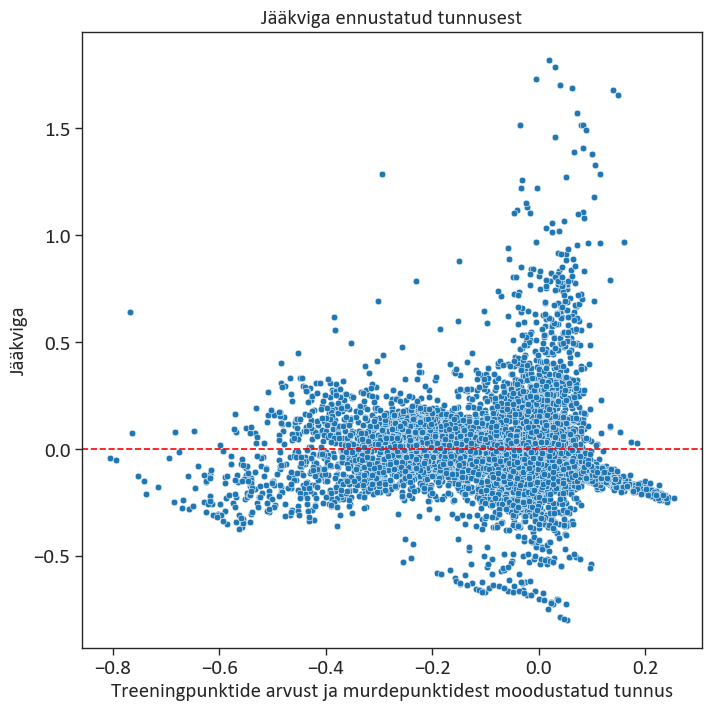

In [35]:
residuals = newy - result6.predict(res6_newX)
x = result6.predict(res6_newX)
sns.scatterplot(x=x, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Treeningpunktide arvust ja murdepunktidest moodustatud tunnus")
plt.ylabel("Jääkviga")
plt.title("Jääkviga ennustatud tunnusest")
plt.savefig("plots/kirjalik_osa/point_ja_bpoint_jaak.png")

## raw_mean jaoks
ei ole mõtet sest r tuleb mingi 0.06

In [36]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      

In [37]:
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

suury = suury - newy - result6.predict(res6_newX)

suurX.drop([col for col in suurX.columns if "raw_mean" not in col], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result7, res7_newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result7.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\raw_mean_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

result7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     358.1
Date:                Thu, 04 May 2023   Prob (F-statistic):          2.87e-218
Time:                        13:02:33   Log-Likelihood:                 4259.3
No. Observations:                8030   AIC:                            -8511.
Df Residuals:                    8026   BIC:                            -8483.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1464      0.005     27.396      0.000       0.136       0.157
my_raw_mean2           -0.4200      0.026    -16.303      0.000      -0.471      -0.370
neighbour_raw_mean2    -0.1364      0.024     -5.681      0.000      -0.183      -0.089
distant_raw_mean2       0.0668      0.016      4.157      0.000       0.035       0.098
==============================================================================
Omnibus:                     1065.234   Durbin-Watson:                   0.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1591.987
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                       3.999   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

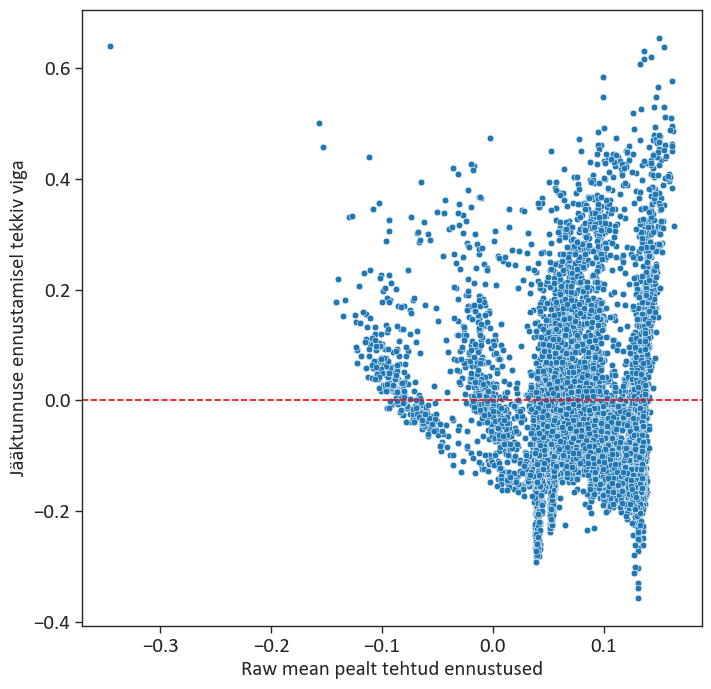

In [38]:
# y7 = kombineeri_tunnus_mudelist_ja_dfist(result7, res7_newX)
y = newy - result7.predict(res7_newX)
x = result7.predict(res7_newX)

fig, ax = plt.subplots()
# ax.set_xscale('log')
def inverse_minimax(X):
    return  X * (1600-2) + 2
sns.scatterplot(x=x, y=y, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)
plt.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel("Raw mean pealt tehtud ennustused")
ax.set_ylabel("Jääktunnuse ennustamisel tekkiv viga")

plt.savefig("plots/kirjalik_osa/raw_mean_combo_jaak.png")

## Vaatame mis kombod olemas on juba

In [39]:
Xid, yid = [],[]

for r, n, k in regioonide_combod:
    
    andmestikud_koos = pd.concat([utils.read_aggregated_data(paths[p]) for p in range(4)], ignore_index=True)

    X, y = utils.transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)      

In [40]:

suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

uuritavad_col = suurX.columns
reg_scaler = MinMaxScaler()
suurX = reg_scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)

# TODO üle käia ega need olemasolevad elemendid ei muutu
suurX["my_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result1, suurX)
suurX["neighbour_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result2, suurX)
suurX["distant_points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result3, suurX)

suurX["points_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result4, suurX)
suurX["bpoints_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result5, suurX)

# suurX["raw_mean_combo"] = kombineeri_tunnus_mudelist_ja_dfist(result6, suurX)

# 'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
# 'mse_treeningul', 'points_combo', 'bpoints_combo'

suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
        'my_points','neighbour_points_combo', 'my_points_combo', 
       'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
       'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
       'distant_points_logm1',
      #  'my_raw_mean2','neighbour_raw_mean2', 'distant_raw_mean2',
         ], axis=1, inplace=True)

# suurX = muuda_veergude_nimed_eestikeelseks(suurX)
result8, newX, newy = treeni_ols(suurX, suury)
regressioon_mudel, newX, newy = treeni_ols(suurX, suury)

summary_table = pd.read_html(result8.summary().as_html(), header=0, index_col=0)
with pd.ExcelWriter(r"plots\kirjalik_osa\engineered_kaalud.xlsx", engine='openpyxl') as writer:
    summary_table[1].to_excel(writer, sheet_name="Summary", startrow=0, startcol=0, index=True)

# print("MSE treeningul: ", mean_squared_error(newy, result8.predict(newX)))
result8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     976.0
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        13:02:43   Log-Likelihood:                 1894.8
No. Observations:                8030   AIC:                            -3776.
Df Residuals:                    8023   BIC:                            -3727.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1580      0.008    -19.550      0.000      -0.174      -0.142
my_raw_mean2           -0.0997      0.037     -2.718      0.007      -0.172      -0.028
neighbour_raw_mean2     0.5430      0.034     15.793      0.000       0.476       0.610
distant_raw_mean2       0.6319      0.025     25.161      0.000       0.583       0.681
mse_treeningul         -0.2865      0.013    -22.034      0.000      -0.312      -0.261
points_combo            1.0355      0.020     52.004      0.000       0.996       1.075
bpoints_combo           0.8764      0.026     33.520      0.000       0.825       0.928
==============================================================================
Omnibus:                     3524.697   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42868.980
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                      13.749   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

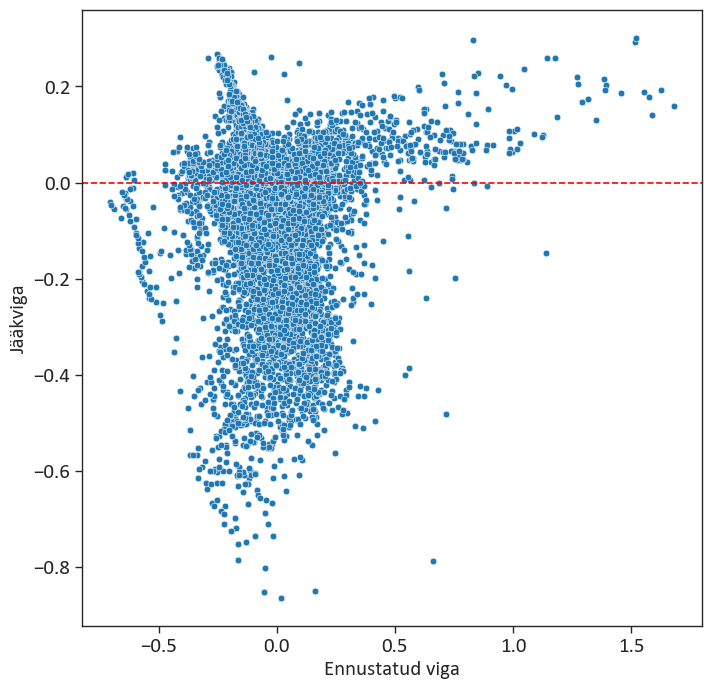

In [41]:
y8 = kombineeri_tunnus_mudelist_ja_dfist(result8, newX)
x8 = newy - result8.predict(newX)

fig, ax = plt.subplots()
sns.scatterplot(x=x8, y=y8, ax=ax)#, hue=tagavarasuurX.distant_raw_mean2)
plt.axhline(y=0, color='r', linestyle='--')

ax.set_xlabel("Ennustatud viga")
ax.set_ylabel("Jääkviga")

plt.savefig("plots/kirjalik_osa/final.png")

In [42]:
import pickle
with open('ols_model.pkl', 'wb') as f:
    pickle.dump(regressioon_mudel, f)
with open('regression_scaler.pkl', 'wb') as f:
    pickle.dump(reg_scaler, f)

# Jääksutunnused

In [43]:
np.abs(regressioon_mudel.params)

const                  0.157993
my_raw_mean2           0.099671
neighbour_raw_mean2    0.542951
distant_raw_mean2      0.631871
mse_treeningul         0.286550
points_combo           1.035521
bpoints_combo          0.876438
dtype: float64

In [44]:
np.argsort(np.abs(regressioon_mudel.params))

const                  1
my_raw_mean2           0
neighbour_raw_mean2    4
distant_raw_mean2      2
mse_treeningul         3
points_combo           6
bpoints_combo          5
dtype: int64

In [45]:
for a in np.argsort(np.abs(regressioon_mudel.params))[-2::-1]:
    print(regressioon_mudel.params[a])

0.8764377612107305
0.631871147325703
0.542951354933315
-0.28654966467793636
-0.15799272615522303
-0.09967090134387427


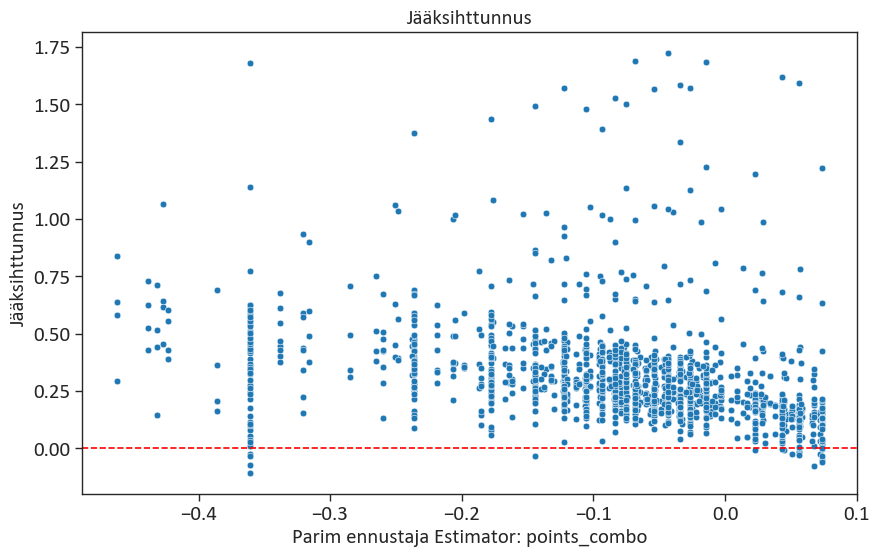

In [46]:
model = regressioon_mudel
best_estimator = newX.columns[np.argmax(np.abs(model.params))]

y_pred = model.predict(newX)
residuals = y - y_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=newX[best_estimator], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Parim ennustaja Estimator: {best_estimator}')
plt.ylabel('Jääksihttunnus')
plt.title('Jääksihttunnus')
plt.show()

bpoints_combo


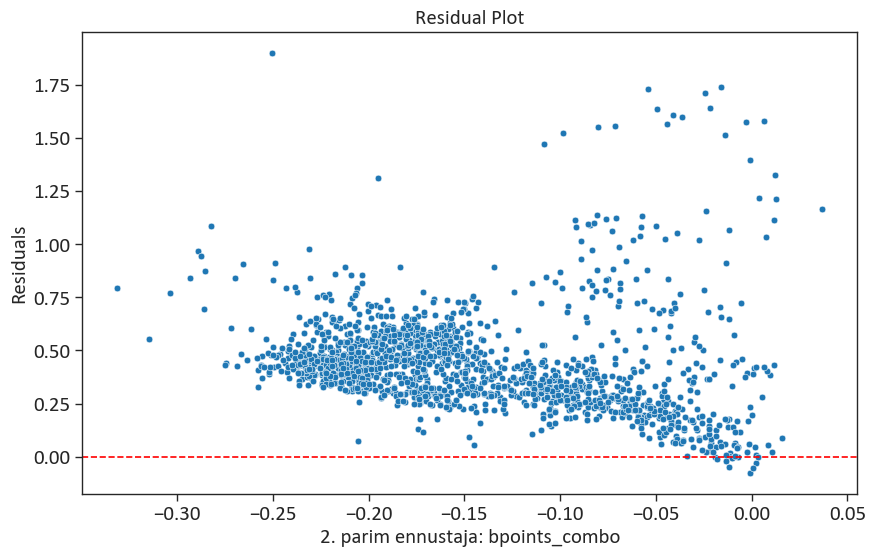

distant_raw_mean2


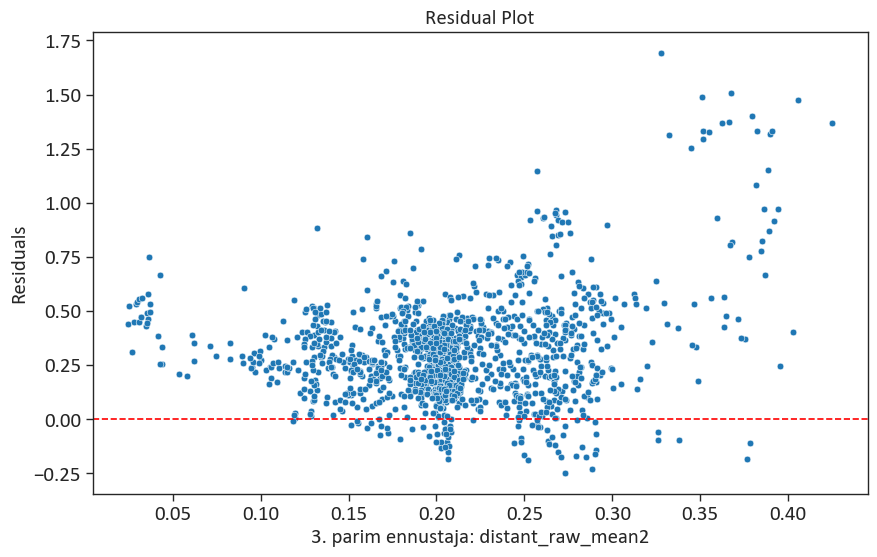

neighbour_raw_mean2


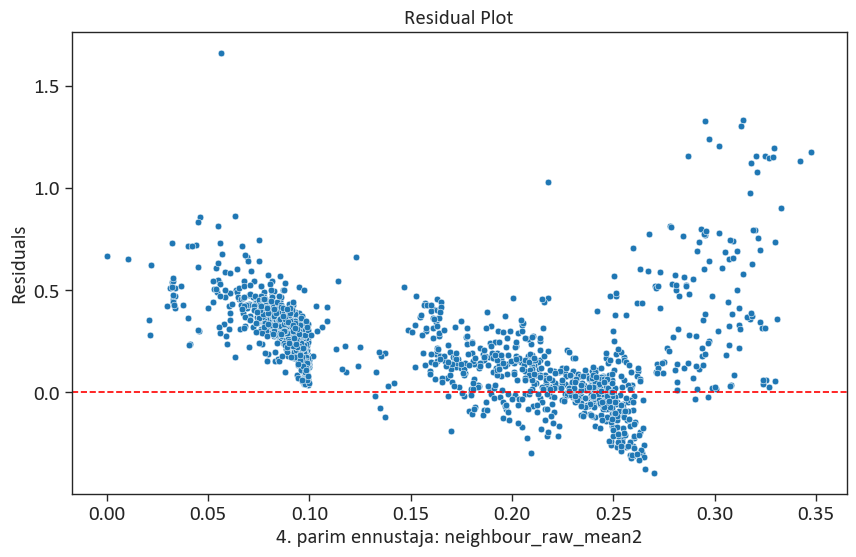

mse_treeningul


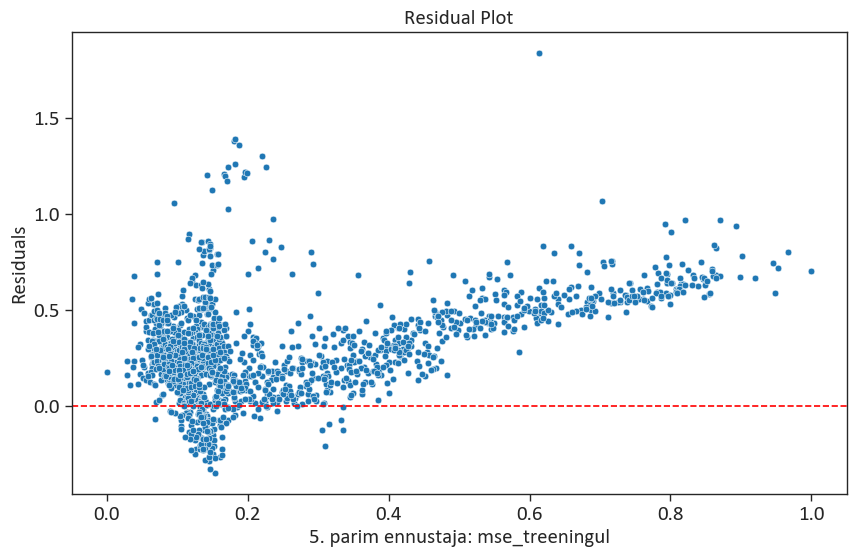

const


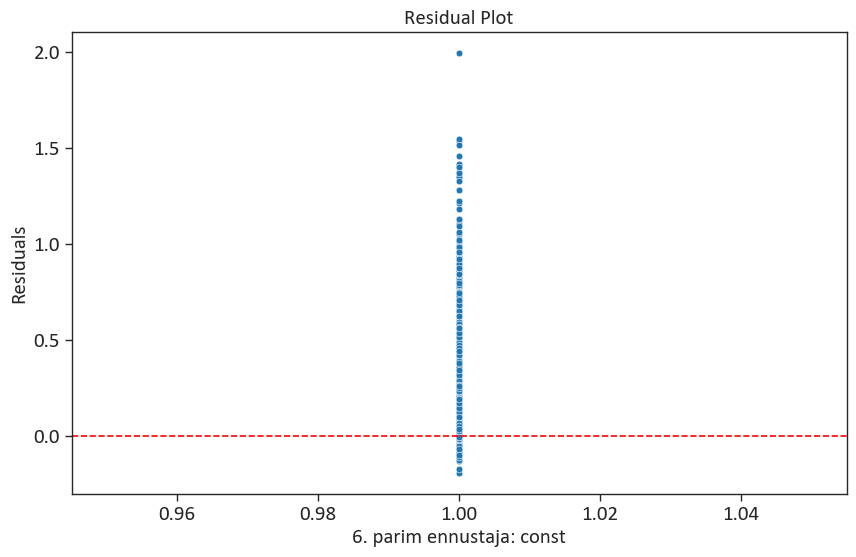

my_raw_mean2


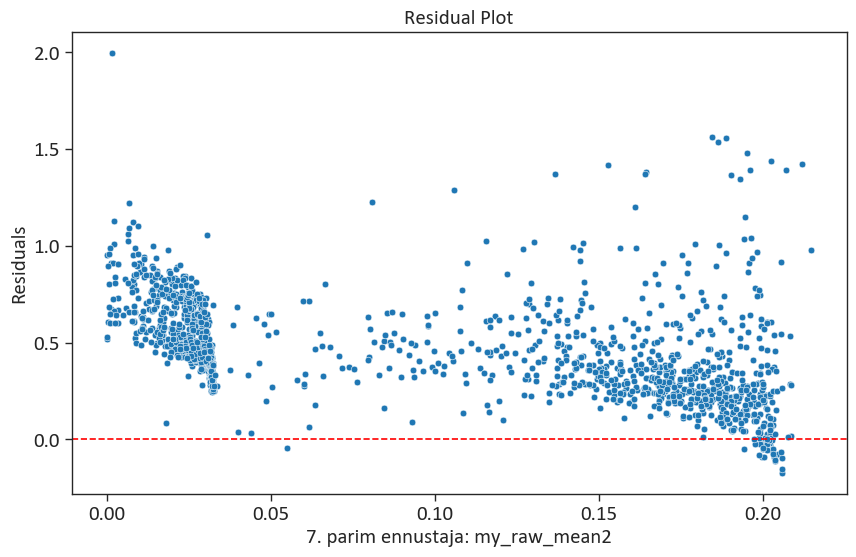

In [47]:
jarjekord = np.argsort(np.abs(regressioon_mudel.params))[-2::-1]
for idx, best_est in enumerate(jarjekord):
    best_est = model.params.keys()[best_est]
    print(best_est)
    residuals = residuals - model.params[best_est] * newX[best_est]
    # Create the residual plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=newX[best_est], y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'{idx+2}. parim ennustaja: {best_est}')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

# Jääktunnused v2
jääk - vist oli mõte nii, et kõige parema järgi teha ennustused ja siis joonistada x-teljele paremuselt teine tunnus ja y-teljele esimesest jäänud jääk. Ehk natuke sarnane selle lingi taga olevale teisele joonisele, aga x-telg oleks juba see teine tunnus. Vist...?

In [48]:
for a in np.argsort(np.abs(regressioon_mudel.params))[::-1]:
    print(newX.columns[a], a, regressioon_mudel.params[a])


points_combo 5 1.0355212966328016
bpoints_combo 6 0.8764377612107305
distant_raw_mean2 3 0.631871147325703
neighbour_raw_mean2 2 0.542951354933315
mse_treeningul 4 -0.28654966467793636
const 0 -0.15799272615522303
my_raw_mean2 1 -0.09967090134387427


points_combo 1.0355212966328016


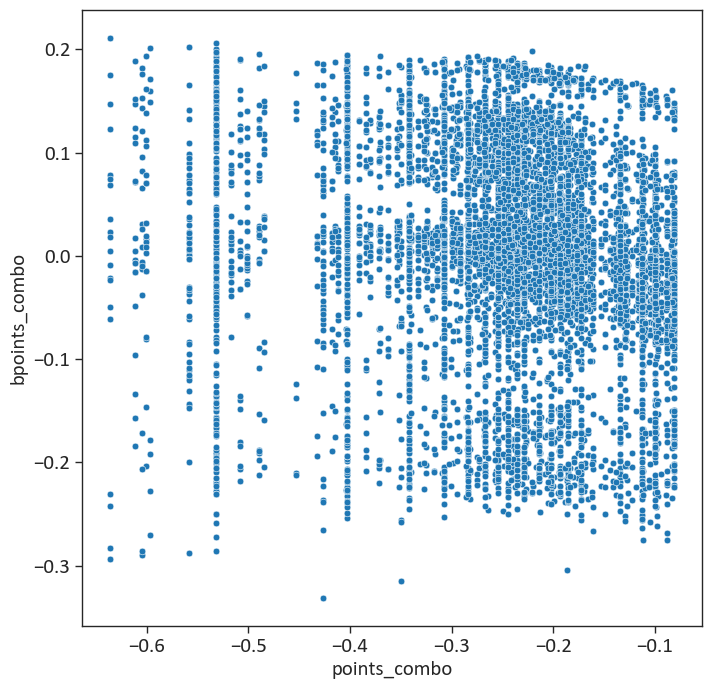

bpoints_combo


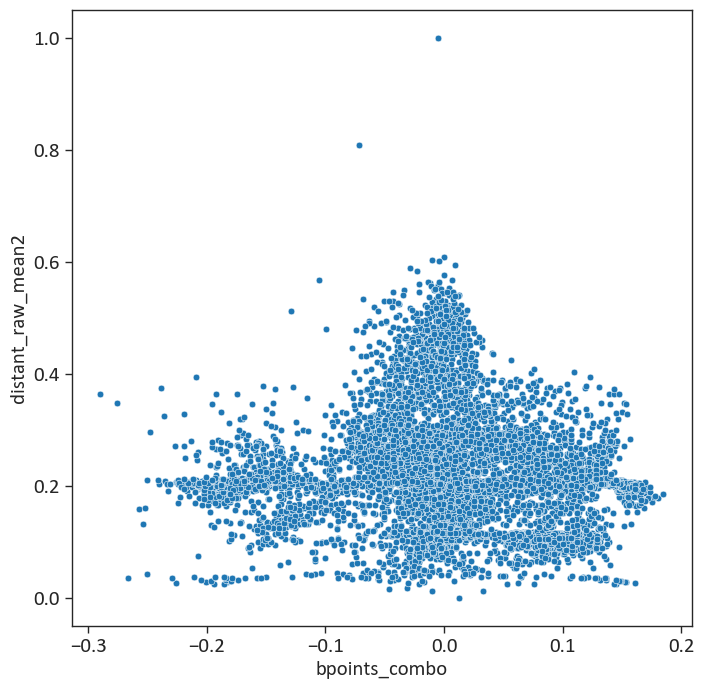

distant_raw_mean2


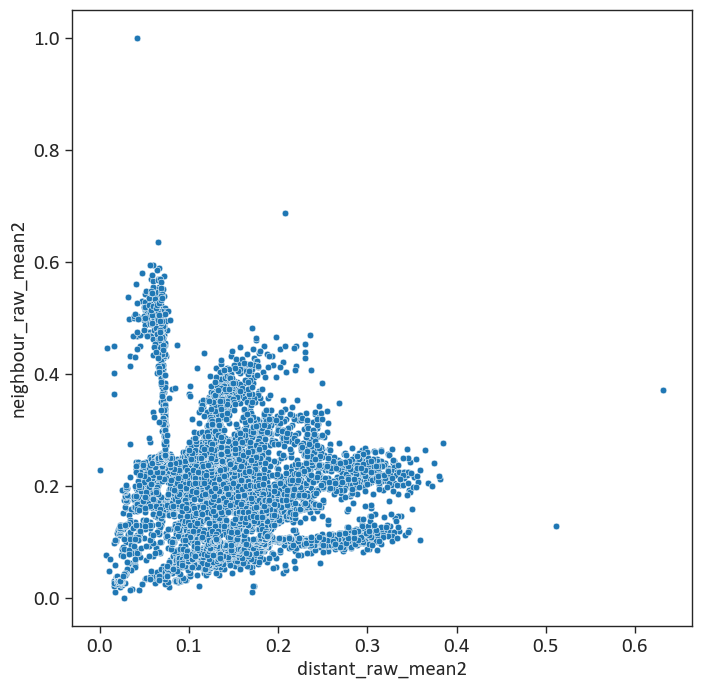

neighbour_raw_mean2


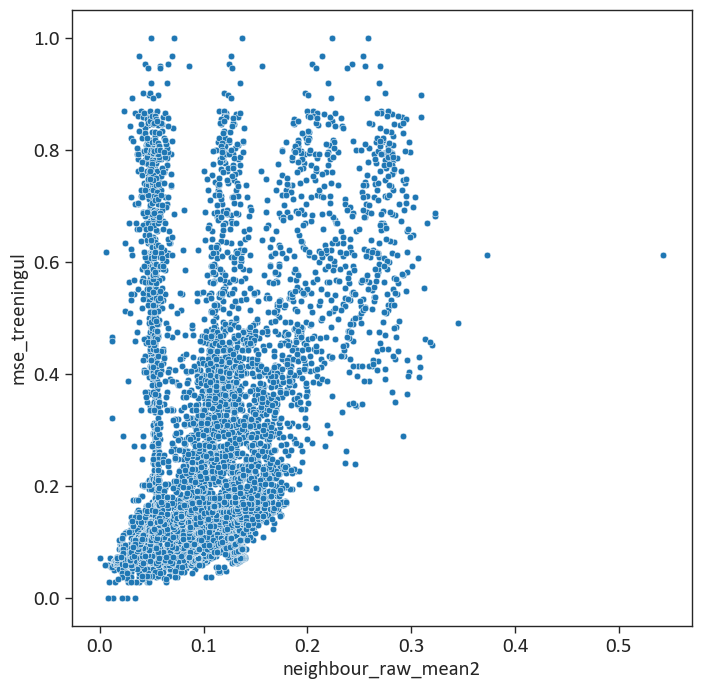

mse_treeningul


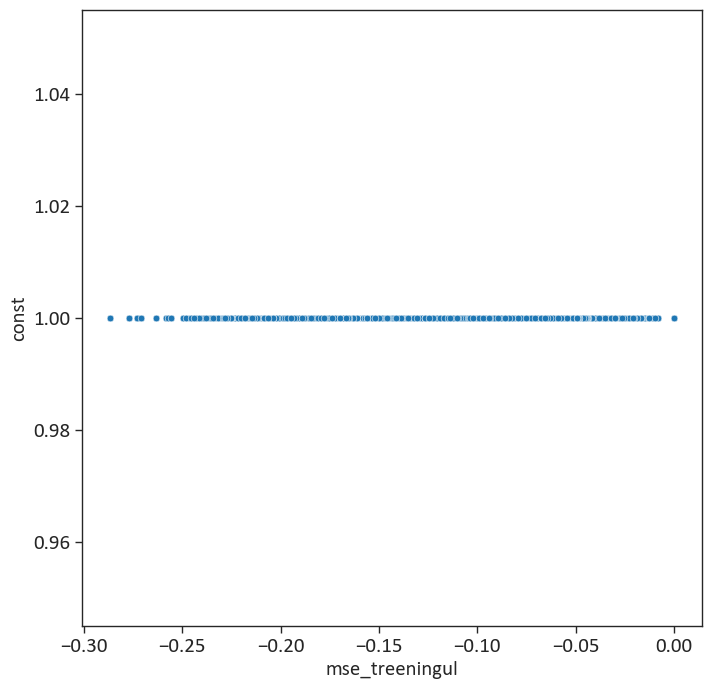

const


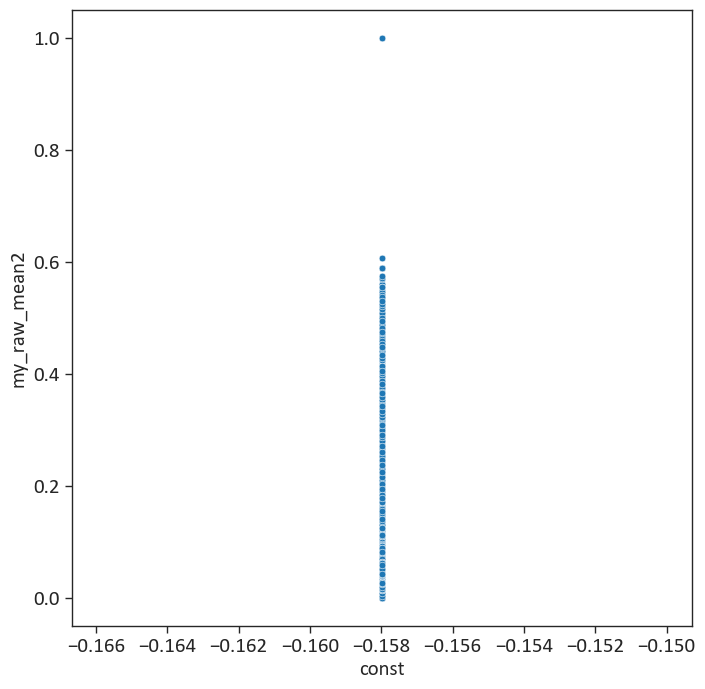

my_raw_mean2


IndexError: index 7 is out of bounds for axis 0 with size 7

In [49]:
model = regressioon_mudel
jarjekord = np.argsort(np.abs(regressioon_mudel.params))[::-1]


j = jarjekord[0]

y_pred = newX[newX.columns[j]] * model.params[j] + np.ones(shape=newX.shape[0]) * model.params["const"]

print(newX.columns[j], model.params[j])
sns.scatterplot(x=y_pred, y=newX[newX.columns[jarjekord[0+1]]])
plt.xlabel(f"{newX.columns[j]}")
plt.show()

for idx, i in enumerate(jarjekord[1:], start=1):
    col = newX.columns[i] 
    print(col)
    y_pred = newX[col] * model.params[col]
    sns.scatterplot(x=y_pred, y=newX[newX.columns[jarjekord[idx+1]]])
    plt.xlabel(f"{col}")
    plt.show()

# Jamps

<AxesSubplot: ylabel='Count'>

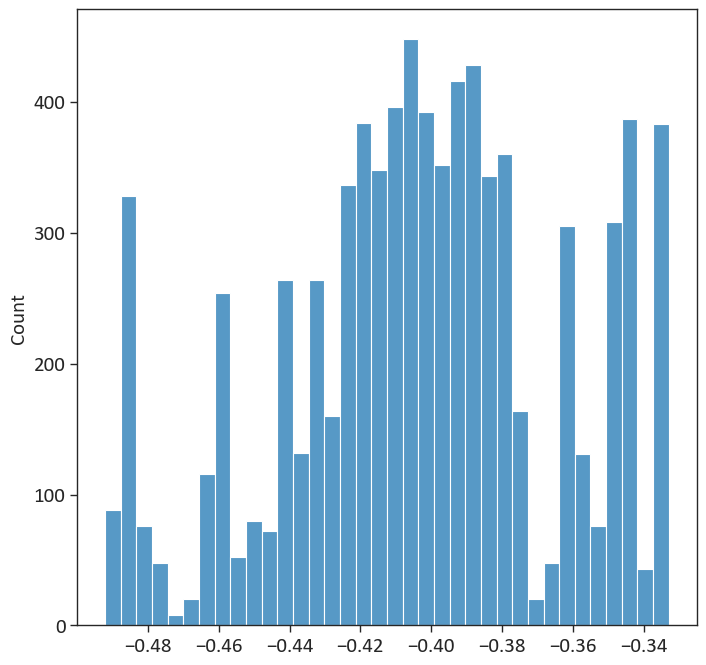

In [ ]:
from scipy.stats import boxcox

sns.histplot(boxcox(suurX.points_combo+0.5)[0])

# Loeme sisse ja ennustame?

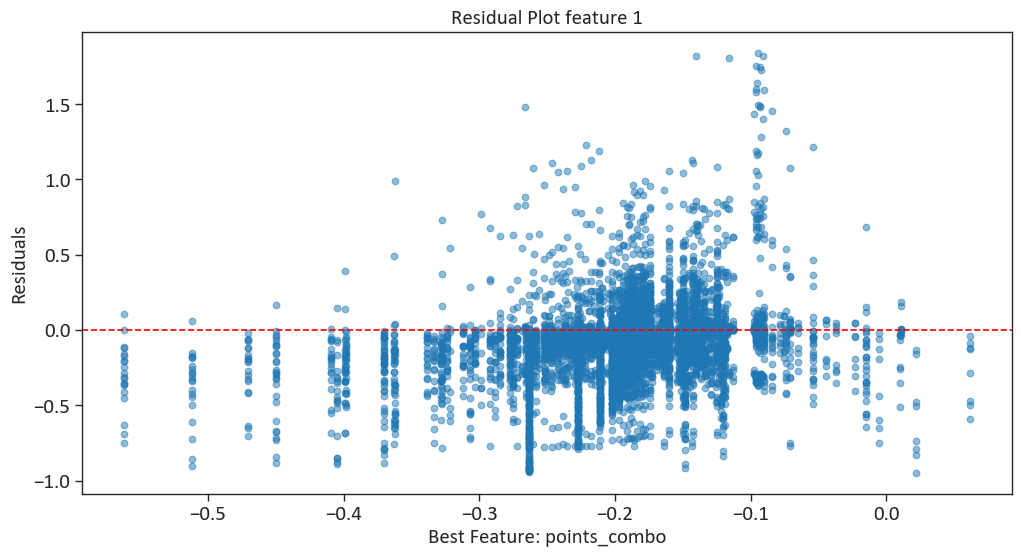

In [ ]:
# Make predictions on the test set
y_pred = regressioon_mudel.predict(newX)

# Calculate the residuals
residuals = newy - y_pred

# Plot the residual plot with the best feature on the x-axis
x = newX.points_combo * result7.params["points_combo"] + result7.params["const"]
plt.figure(figsize=(12, 6))
plt.scatter(x=x, y=newy, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f"Best Feature: points_combo")
plt.ylabel("Residuals")
plt.title("Residual Plot feature 1")
plt.show()


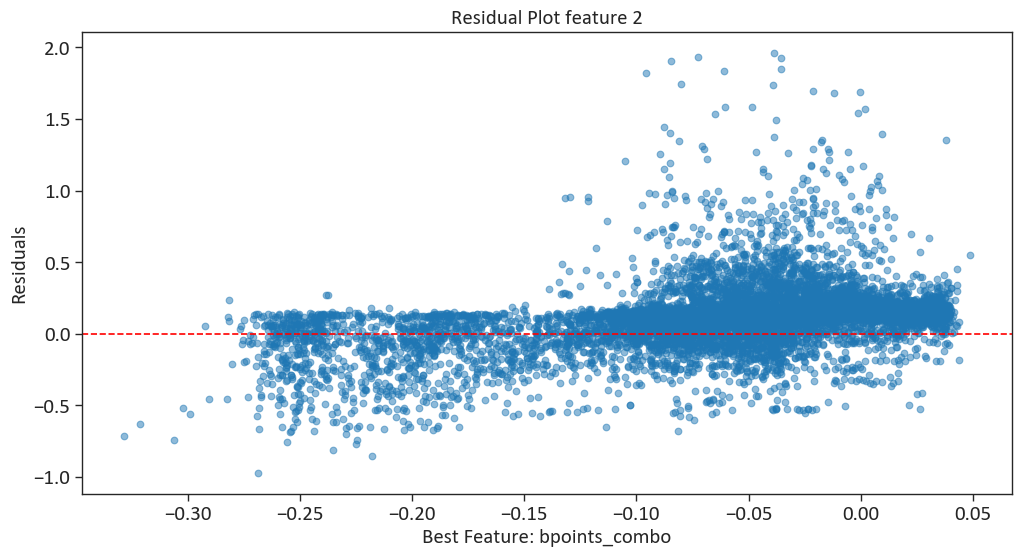

In [ ]:
# Make predictions on the test set

# Calculate the residuals
y2 = newy - x

# Plot the residual plot with the best feature on the x-axis
x2 = newX.bpoints_combo * result7.params["bpoints_combo"] 
plt.figure(figsize=(12, 6))
plt.scatter(x=x2, y=y2, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f"Best Feature: bpoints_combo")
plt.ylabel("Residuals")
plt.title("Residual Plot feature 2")
plt.show()